In [ ]:
!pip install -q tensorflow-text

     |████████████████████████████████| 4.9 MB 8.8 MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd

In [ ]:
train_data = pd.read_csv('gdrive/MyDrive/Colab Notebooks/jigsaw/train_1st_competition.csv')
test_data = pd.read_csv('gdrive/MyDrive/Colab Notebooks/jigsaw/valid_combined.csv', index_col=0)

In [ ]:
train_data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [ ]:
def total(x):
  total_score = x.toxic + x.severe_toxic + x.obscene + x.threat + x.insult + x.identity_hate
  return total_score

train_data["total_score"] = train_data[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].apply(total, axis=1)

In [ ]:
TRAIN = train_data[["comment_text","total_score"]]

In [ ]:
TRAIN

,comment_text,total_score
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


In [ ]:
TRAIN.total_score.value_counts()

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
Name: total_score, dtype: int64

In [ ]:
# classify as toxic and non-toxic only

TRAIN["total_score"] = TRAIN["total_score"].apply(lambda x: 0 if x == 0 else 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
TRAIN

,comment_text,total_score
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


In [ ]:
TRAIN.total_score.value_counts()   #imbalance data

0    143346
1     16225
Name: total_score, dtype: int64

In [ ]:
# up-sampling

# class count
majority, minority = TRAIN.total_score.value_counts()

In [ ]:
# divide by class
TRAIN_majority = TRAIN[TRAIN['total_score'] == 0]
TRAIN_minority = TRAIN[TRAIN['total_score'] == 1]

In [ ]:
# scale up the minority

TRAIN_minority_up = TRAIN_minority.sample(majority, replace=True)

In [ ]:
# concat to form a new/final dataframe

TRAIN_final = pd.concat([TRAIN_majority, TRAIN_minority_up], axis=0)

In [ ]:
TRAIN_final.shape

(286692, 2)

In [ ]:
TRAIN_final.total_score.value_counts(normalize=True)   # imbalance problem solved!!!

1    0.5
0    0.5
Name: total_score, dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(TRAIN_final['comment_text'], TRAIN_final['total_score'], stratify=TRAIN_final['total_score'])


In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [ ]:
len(X_train)

215019

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# The following cell takes 2 hours to run

In [ ]:
hist = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
6720/6720 [==============================] - 1766s 262ms/step - loss: 0.3916 - accuracy: 0.8252 - val_loss: 0.3279 - val_accuracy: 0.8598
Epoch 2/5
6720/6720 [==============================] - 1753s 261ms/step - loss: 0.3518 - accuracy: 0.8453 - val_loss: 0.3168 - val_accuracy: 0.8645
Epoch 3/5
6720/6720 [==============================] - 1755s 261ms/step - loss: 0.3495 - accuracy: 0.8467 - val_loss: 0.3101 - val_accuracy: 0.8698
Epoch 4/5
6720/6720 [==============================] - 1759s 262ms/step - loss: 0.3478 - accuracy: 0.8480 - val_loss: 0.3166 - val_accuracy: 0.8660
Epoch 5/5
6720/6720 [==============================] - 1758s 262ms/step - loss: 0.3463 - accuracy: 0.8476 - val_loss: 0.3164 - val_accuracy: 0.8632


In [ ]:
hist.history

{'accuracy': [0.8251829147338867,
  0.8453066945075989,
  0.8466972708702087,
  0.8480413556098938,
  0.8475948572158813],
 'loss': [0.3915517330169678,
  0.3518097400665283,
  0.34949788451194763,
  0.34779179096221924,
  0.34626173973083496],
 'val_accuracy': [0.8597937822341919,
  0.8644956946372986,
  0.8698254823684692,
  0.8659746050834656,
  0.8632121086120605],
 'val_loss': [0.3279489576816559,
  0.3167661726474762,
  0.3100632429122925,
  0.31664058566093445,
  0.3163880407810211]}

In [ ]:
#   Evaluate the model with the test data to get the scores on "real" data.
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', round(score[0], 3))
print('Test accuracy:', round(score[1], 3))

Test loss: 0.316
Test accuracy: 0.863


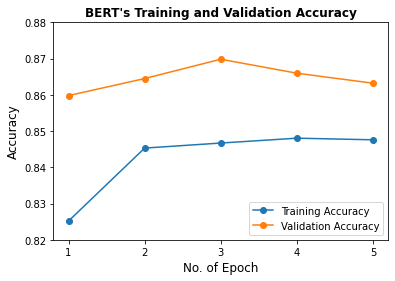

In [ ]:
#   Plot data to see relationships in training and validation data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
epoch_list = list(range(1, len(hist.history['accuracy']) + 1))  # values for x axis [1, 2, ..., # of epochs]

plt.xticks(np.arange(1, 6, 1))
plt.ylim([0.82, 0.88])

plt.plot(epoch_list, hist.history['accuracy'], epoch_list, hist.history['val_accuracy'], marker='o')
plt.title("BERT's Training and Validation Accuracy", fontsize=12, fontweight="bold")
plt.xlabel('No. of Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(('Training Accuracy', 'Validation Accuracy'), loc='lower right')
plt.savefig('gdrive/MyDrive/Colab Notebooks/jigsaw/BERT.png', bbox_inches='tight')
plt.show()

In [ ]:
model.predict(test_data["comment_text"])

array([[0.48704454],
       [0.13841648],
       [0.9360812 ],
       ...,
       [0.99326503],
       [0.99326503],
       [0.99326503]], dtype=float32)

In [ ]:
pred = model.predict(test_data["comment_text"])

In [ ]:
result = pd.DataFrame(pred)

In [ ]:
result

,0
0,0.487045
1,0.138416
2,0.936081
3,0.908850
4,0.869992
...,...
60211,0.928053
60212,0.928053
60213,0.993265
60214,0.993265


In [ ]:
result.to_csv('gdrive/MyDrive/Colab Notebooks/BERTv3_result.csv')